# Convolutional Autoencoder and Classifier for Cifar-10

In [0]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt


def denorm(x, channels=None, w=None ,h=None, resize = False):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    if resize:
        if channels is None or w is None or h is None:
            print('Number of channels, width and height must be provided for resize.')
        x = x.view(x.size(0), channels, w, h)
    return x

def show(img):
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))


### Device Selection

In [2]:
GPU = True
device_idx = 1
if GPU:
    device = torch.device("cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

cuda:1


### Reproducibility

In [3]:
# set a random seed
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

### Data loading

In [5]:
batch_size = 128

if not os.path.exists('./CAE'):
    os.makedirs('./CAE')

NUM_TRAIN = 49000

transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])


data_dir = './datasets'
cifar10_train = datasets.CIFAR10(data_dir, train=True, download=True,
                             transform=transform)
cifar10_val = datasets.CIFAR10(data_dir, train=True, download=True,
                           transform=transform)
cifar10_test = datasets.CIFAR10(data_dir, train=False, download=True, 
                            transform=transform)

loader_train = DataLoader(cifar10_train, batch_size=batch_size, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
loader_val = DataLoader(cifar10_val, batch_size=batch_size, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))
loader_test = DataLoader(cifar10_test, batch_size=batch_size)

it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:32, :, :, :]
save_image(denorm(fixed_input), './CAE/input_sample.png')

Files already downloaded and verified
Files already downloaded and verified


## Convolutional Autoencoder

### Hyper-parameter selection

In [0]:
### the number of epochs and the learning rate.
num_epochs = 20
learning_rate  = 0.001

### Define model

In [0]:
### value for the latent space dimension
hidden_size = 1024

class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=4, stride=2, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=0),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=128, out_channels=3, kernel_size=4, stride=2, padding=0),
            nn.Tanh(),
        )
        self.shape1 = 256
        self.shape2 = 3
        self.shape3 = 3
        self.fc1 = nn.Linear(in_features=self.shape1*self.shape2*self.shape3, out_features=hidden_size)
        self.fc2 = nn.Linear(in_features=hidden_size, out_features=self.shape1*self.shape2*self.shape3)
    

    def encode(self, x):
        
        x = self.encoder(x)
        x = x.view(x.size(0),-1)
        x = self.fc1(x)
        return x
  
    
    def decode(self, z):
        

        z = self.fc2(z)
        z = z.view(z.size(0), self.shape1, self.shape2, self.shape3)
        z = self.decoder(z)
        return z
     

    def forward(self, x):
        z = self.encode(x)
        recon = self.decode(z)
        return recon

### Define Loss function

In [0]:
criterion = nn.MSELoss(reduction='mean')
def loss_function_CAE(recon_x, x):
    recon_loss = criterion(recon_x, x)
    return recon_loss

### Initialize Model and print number of parameters

In [0]:
model = CAE().to('cuda')
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
print(model)

Total number of parameters is: 6506243
CAE(
  (encoder): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2))
    (7): Tanh()
  )
  (fc1): Linear(in_features=2304, out_fea

### Choose and initialize optimizer

In [0]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Train

In [0]:
train_losses = []
model.train()
for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, data in enumerate(loader_train):
        img, _ = data
        img = img.to('cuda')
        optimizer.zero_grad()
        # forward
        recon_batch = model(img)
        loss = loss_function_CAE(recon_batch, img)
        # backward
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    # print out losses and save reconstructions for every epoch
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, train_loss / len(loader_train)))
    recon = model(fixed_input.to('cuda'))
    recon = denorm(recon.cpu())
    save_image(recon, './CAE/reconstructed_epoch_{}.png'.format(epoch))
    train_losses.append(train_loss/ len(loader_train))

# save the model and the loss values
np.save('./CAE/train_losses.npy', np.array(train_losses))
torch.save(model.state_dict(), './CAE/CAE_model.pth')

epoch [1/20], loss:0.0721
epoch [2/20], loss:0.0313
epoch [3/20], loss:0.0227
epoch [4/20], loss:0.0187
epoch [5/20], loss:0.0159
epoch [6/20], loss:0.0144
epoch [7/20], loss:0.0129
epoch [8/20], loss:0.0117
epoch [9/20], loss:0.0111
epoch [10/20], loss:0.0103
epoch [11/20], loss:0.0096
epoch [12/20], loss:0.0092
epoch [13/20], loss:0.0088
epoch [14/20], loss:0.0084
epoch [15/20], loss:0.0080
epoch [16/20], loss:0.0078
epoch [17/20], loss:0.0074
epoch [18/20], loss:0.0070
epoch [19/20], loss:0.0069
epoch [20/20], loss:0.0066


### Train loss curve

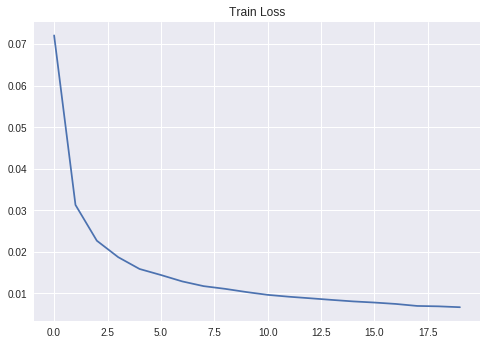

In [0]:
import matplotlib.pyplot as plt
train_losses = np.load('./CAE/train_losses.npy')
plt.plot(list(range(0,train_losses.shape[0])), train_losses)
plt.title('Train Loss')
plt.show()

### Test set reconstruction error

In [0]:
# load the model
model.load_state_dict(torch.load('./CAE/CAE_model.pth'))
model.eval()
test_loss = 0
with torch.no_grad():
    for i, data in enumerate(loader_test):
        img,_ = data
        img = img.to('cuda')
        recon_batch = model(img)
        test_loss += loss_function_CAE(recon_batch, img)
    # loss calculated over the whole test set
    test_loss /= len(loader_test.dataset)
    print('Test set loss: {:.4f}'.format(test_loss))

Test set loss: 0.0000


### Test set images and reconstructions

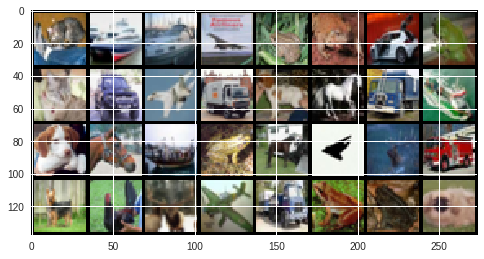

In [0]:
# load the model
model.load_state_dict(torch.load('./CAE/CAE_model.pth'))
it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:32, :, :, :]

# visualize the original images of the last batch of the test set
img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
show(img)

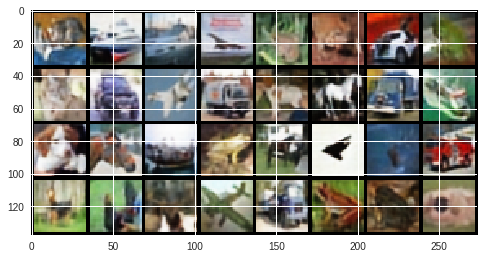

In [0]:
with torch.no_grad():
    # visualize the reconstructed images of the last batch of test set
    recon_batch = model(fixed_input.to('cuda')).cpu()
    recon_batch = make_grid(denorm(recon_batch), nrow=8, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    show(recon_batch)

### Define Classifier

In [0]:
num_classes = 10

class the_classifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.size1 = 1024
        self.size2 = 512
        self.size3 = 128
        self.fc1 = nn.Linear(input_size, self.size1)
        self.fc2 = nn.Linear(self.size1, self.size2)
        self.fc3 = nn.Linear(self.size2, self.size3)
        self.fc4 = nn.Linear(self.size3, num_classes)
  
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        return x

my_classifier = the_classifier(hidden_size, num_classes).to('cuda')

optimizer = torch.optim.Adam(my_classifier.parameters(), lr=1e-4)
for e in range(5):  #epochs
    print("Epoch:", e)
    train_loss = 0
    for batch_idx, data in enumerate(loader_train):
        img, label = data
        img = img.cuda()
        label = label.cuda()
        latent_repre = model.encode(img)
        optimizer.zero_grad()
        y_pred = my_classifier(latent_repre)
        loss = F.cross_entropy(y_pred, label)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print('loss:', train_loss / len(loader_train))

Epoch: 0
loss: 1.6284259753812387
Epoch: 1
loss: 1.2756782256592036
Epoch: 2
loss: 1.0673386011048958
Epoch: 3
loss: 0.8776950335066872
Epoch: 4
loss: 0.7024416327476501


In [0]:
acc = 0
count = 0
test_loss = 0
with torch.no_grad():
    for i, data in enumerate(loader_test):
        img, label = data
        img = img.to('cuda')
        label = label.to('cuda')
        latent_repre = model.encode(img)
        y_pred = my_classifier(latent_repre)
        loss = F.cross_entropy(y_pred, label)
        test_loss += loss.item()
        _, y_pred = torch.max(F.softmax(y_pred, 1), 1)
        acc += sum(y_pred == label).item()
        count += len(label)
accuracy = acc / count
print("test loss:", test_loss/len(loader_test))
print('Classification accuracy: {:.4f}'.format(accuracy))

test loss: 1.347178172461594
Classification accuracy: 0.5513
